# Transfer learning with Keras

In [1]:
# useful imports
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from matplotlib.legend_handler import HandlerLine2D
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import regularizers
from keras.optimizers import SGD
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import numpy as np

Using TensorFlow backend.
/home/chris/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/chris/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/chris/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/chris/.local/lib/python3.6/site-packages/tensorflow/python/fra

### Activation functions

In [2]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x)*(1.0 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - x ** 2

def relu(x):
    return np.maximum(0,x)

def relu_prime(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def leakyrelu(x):
    return np.maximum(0.01,x)

def leakyrelu_prime(x):
    x[x<=0] = 0.01
    x[x>0] = 1
    return x

def softmax(x):
    expx = np.exp(x - np.max(x))
    return expx / expx.sum(axis=0, keepdims=True)

#### Creation of learning and testing datasets 

Test with multiclass classification

In [3]:
%store -r preprocessed_images
X, y = preprocessed_images

# mélange des données
#df = df.sample(frac=1).reset_index(drop=True)

In [4]:
# Conversion de la variable à prédire via OneHotEncoder 

# Integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

In [5]:
# View repartition by species
# sns.countplot(y)

# And shape
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (3474, 100, 100, 3)
Shape of y: (3474, 50)


In [6]:
# Jeu de test/apprentissage

from sklearn.model_selection import train_test_split 
validation_size=0.8 #20% du jeu de données pour le test

testsize= 1-validation_size
seed=42
# séparation jeu d'apprentissage et jeu de test
X_train,X_test,y_train,y_test=train_test_split(X, 
                                               y,  
                                               random_state=seed,
                                               test_size=testsize)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape, "\n")

Shape of X_train: (2779, 100, 100, 3)
Shape of X_test: (695, 100, 100, 3)
Shape of y_train: (2779, 50)
Shape of y_test: (695, 50) 



In [7]:
import gc
del X 
del y
gc.collect()

ntrain = len(X_train)
nval = len(X_test)

batch_size = 32

In [8]:
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

In [9]:
from keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(100, 100, 3))



219062272/219055592 [==============================] - 139s 1us/step


In [10]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 49, 49, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 49, 49, 32)   0           batch_normalization_1[0][0]      
________________________________________________________________________________

In [11]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(50, activation='softmax'))  

In [12]:
# Check the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1, 1, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               786944    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                25650     
Total params: 55,149,330
Trainable params: 55,088,786
Non-trainable params: 60,544
_________________________________________________________________


In [13]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 492
Number of trainable weights after freezing the conv base: 4


In [15]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_test, y_test, batch_size=batch_size)

In [19]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=ntrain // batch_size,
                             epochs=64,
                             validation_data=val_generator,
                             validation_steps=nval // batch_size)

Epoch 1/64
86/86 [==============================] - 44s 506ms/step - loss: 3.2624 - acc: 0.2184 - val_loss: 3.6633 - val_acc: 0.0893
Epoch 2/64
86/86 [==============================] - 47s 547ms/step - loss: 3.2293 - acc: 0.2162 - val_loss: 3.7138 - val_acc: 0.0905
Epoch 3/64
86/86 [==============================] - 47s 545ms/step - loss: 3.2180 - acc: 0.2232 - val_loss: 3.8876 - val_acc: 0.0935
Epoch 4/64
86/86 [==============================] - 47s 547ms/step - loss: 3.2005 - acc: 0.2290 - val_loss: 3.5666 - val_acc: 0.0995
Epoch 5/64
86/86 [==============================] - 47s 549ms/step - loss: 3.1820 - acc: 0.2333 - val_loss: 3.8588 - val_acc: 0.1041
Epoch 6/64
86/86 [==============================] - 47s 546ms/step - loss: 3.1227 - acc: 0.2468 - val_loss: 3.8903 - val_acc: 0.1026
Epoch 7/64
86/86 [==============================] - 47s 551ms/step - loss: 3.1394 - acc: 0.2406 - val_loss: 3.7933 - val_acc: 0.1086
Epoch 8/64
86/86 [==============================] - 47s 550ms/step - 

86/86 [==============================] - 48s 556ms/step - loss: 2.4872 - acc: 0.3688 - val_loss: 3.0585 - val_acc: 0.1961
Epoch 63/64
86/86 [==============================] - 49s 567ms/step - loss: 2.4275 - acc: 0.3844 - val_loss: 3.7228 - val_acc: 0.1765
Epoch 64/64
86/86 [==============================] - 52s 601ms/step - loss: 2.3899 - acc: 0.3928 - val_loss: 3.9866 - val_acc: 0.1870


In [29]:
#Save the model
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

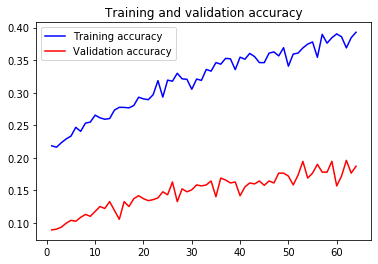

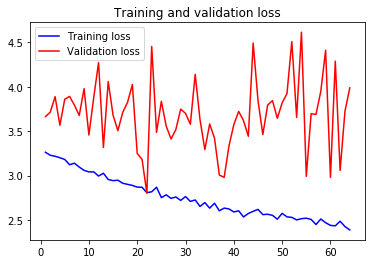

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
